<a href="https://colab.research.google.com/github/ndy-s/transformers-edom/blob/main/Transformers_EDOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code configuration
DATASET_FILE_NAME = 'dataset_edom'
FEB_ONLY = False

MODEL_NAME = 'gpt2'; # mbert, indobert, roberta, gpt2
FREEZE_LAYER = False

# Hyperparameter
BATCH_SIZE = 16 # 16, 32
LEARNING_RATE = 2e-5 # 5e-5, 3e-5, 2e-5
EPOCH = 4 # 2, 3, 4

In [ ]:
import os
from google.colab import files

if not os.path.exists(f'./{DATASET_FILE_NAME}.xlsx'):
  uploaded = files.upload()

In [ ]:
import pandas as pd

df = pd.read_excel(f'./{DATASET_FILE_NAME}.xlsx')

# Pre-processing excel data
df_copy = df.copy()
df_copy = df_copy.drop_duplicates(subset='JAWABAN')
df_copy = df_copy.dropna(subset=['LABEL'])
df_copy = df_copy[df_copy['FAKULTAS'] == 'EKONOMI DAN BISNIS'] if FEB_ONLY else df_copy
df_copy.drop(['KONTEKS', 'FAKULTAS'], axis=1, inplace=True)
df_copy.head()

,JAWABAN,LABEL
0,"Selama proses perkuliahan sudah cukup baik, ha...",NEGATIF
1,selalu menjadi dosen yang memotivasi mahasiswanya,POSITIF
2,tetap jadi dosen yang baik dan seru buk,POSITIF
3,Saya sangat merasa senang ketika belajar di ke...,POSITIF
4,Saran: Jika tidak masuk pada jam yang telah di...,NEGATIF


In [ ]:
# Check if there is any null value in df_copy
assert df_copy.isna().sum().sum() == 0, "Error: There are null values in the DataFrame."

print("No null values found.")
print(df_copy.isna().sum())

No null values found.
JAWABAN    0
LABEL      0
dtype: int64


In [ ]:
# Pre-process label representation
label_value = df_copy['LABEL'].unique()
print("Original unique values in the 'LABEL' column:", label_value)

if 'NETRAL' in label_value:
  df_copy = df_copy[df_copy['LABEL'] != 'NETRAL']
  print("Rows with 'NETRAL' values dropped.")
else:
  print("No 'NETRAL' values found in the 'LABEL' column.")

df_copy['LABEL'] = df_copy['LABEL'].map({
  'NEGATIF': 0,
  'POSITIF': 1
})

print("Unique values after mapping in the 'LABEL' column:", df_copy['LABEL'].unique())

Original unique values in the 'LABEL' column: ['NEGATIF' 'POSITIF' 'NETRAL']
Rows with 'NETRAL' values dropped.
Unique values after mapping in the 'LABEL' column: [0 1]


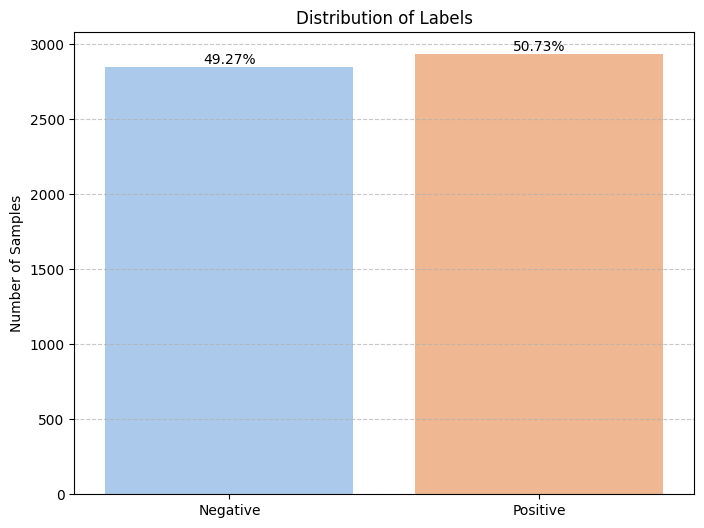

In [ ]:
# Plot distribution of labels
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette("pastel")
label_counts = df_copy['LABEL'].value_counts()

total_samples = len(df_copy['LABEL'])
percentage_distribution = (label_counts / total_samples) * 100

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts, palette=colors)

ax.set_ylabel('Number of Samples')
ax.set_xticklabels(['Negative', 'Positive'])
plt.title('Distribution of Labels')

for i, p in enumerate(ax.patches):
  height = p.get_height()
  ax.annotate(f'{percentage_distribution[i]:.2f}%', (p.get_x() + p.get_width() / 2., height),
              ha='center', va='bottom', fontsize=10, color='black')

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import pandas as pd

sample_df = df_copy.sample(n=15, random_state=42)

sentences = df_copy['JAWABAN'].values
labels = df_copy['LABEL'].values

print("Random Texts and Labels (Sample of 15 entries):")
for i, (sentence, label) in enumerate(zip(sample_df['JAWABAN'], sample_df['LABEL']), 1):
  print(f"{i}. Label: {label} - Text: {sentence}\n")

Random Texts and Labels (Sample of 15 entries):
1. Label: 0 - Text: Izin pak saran saya, penyampaian materi lebih tegas dan lantang, agar tidak mahasiswa tertarik dan tidak menimbulkan efek ngantuk pak. Terimakasih 

2. Label: 1 - Text: No comment karena kami di ganti kan oleh buk XYZ dan dengan XYZ kami enjoy dan ilmunya yg di ajarkan paham

3. Label: 0 - Text: Pembelajaran dengan beliau sangat baik tetepi beberapa kali jam mata kuliah di ganti tidak sesuai jadwal 

4. Label: 0 - Text: Untuk buk XYZ kedepannya tolong jangan suka php mahasiswa

5. Label: 1 - Text: Menurut saya cara pembelajaran ibu sudah baik, karna ibu menjelaskan kepada mahasiswa terkait materi yang sudah kami persiapkan dengan jelas dan ibu juga memberikan kami saran terkait penulisan ppt yang benar. 

6. Label: 1 - Text: Proses perkuliahan sudah sangat baik, sehingga materi yang sudah disampaikan menjadi lebih mudah untuk dipahami. Semoga proses pembelajaran ke depannya tetap aktif dan mahasiswa bisa lebih bersungg

In [ ]:
!pip install transformers -q

In [ ]:
from transformers import BertTokenizer, RobertaTokenizer, GPT2Tokenizer
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, GPT2ForSequenceClassification

def load_tokenizer_and_model(MODEL_NAME):
  model_classes = {
    "mbert": (BertTokenizer, BertForSequenceClassification, 'bert-base-multilingual-uncased'),
    "indobert": (BertTokenizer, BertForSequenceClassification, 'indolem/indobert-base-uncased'),
    "roberta": (RobertaTokenizer, RobertaForSequenceClassification, 'cahya/roberta-base-indonesian-522M'),
    "gpt2": (GPT2Tokenizer, GPT2ForSequenceClassification, 'cahya/gpt2-small-indonesian-522M'),
  }

  if MODEL_NAME.lower() not in model_classes:
    raise ValueError(f"Unsupported model: {MODEL_NAME}")

  tokenizer_class, model_class, model_pretrained = model_classes[MODEL_NAME.lower()]

  tokenizer = tokenizer_class.from_pretrained(model_pretrained, do_lower_case=True)
  model = model_class.from_pretrained(model_pretrained, num_labels=2)

  # Set pad_token for GPT-2
  if MODEL_NAME.lower() == 'gpt2':
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

  return tokenizer, model

In [ ]:
tokenizer, model = load_tokenizer_and_model(MODEL_NAME)

if FREEZE_LAYER:
  if MODEL_NAME == 'gpt2':
    # Freeze all layers except the embedding and positional embedding layers
    for param in model.transformer.wte.parameters():
      param.requires_grad = False
    for param in model.transformer.wpe.parameters():
      param.requires_grad = False
  else:
    # Freeze all layers except the final classification layer
    for param in model.parameters():
      param.requires_grad = False

    # Make the classification layer trainable
    for param in model.classifier.parameters():
      param.requires_grad = True

# Check the tokenization process results
print("Original Sentence: ", sentences[0])
print("Tokenized Sentence: ", tokenizer.tokenize(sentences[0]))
print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at cahya/gpt2-small-indonesian-522M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original Sentence:  Selama proses perkuliahan sudah cukup baik, hanya saja untuk pertemuan terakhir sebelum UAS dosen jarang masuk sehingga materi nya kurang dipahami mahasiswa 
Tokenized Sentence:  ['Selama', 'Ġproses', 'Ġperkuliahan', 'Ġsudah', 'Ġcukup', 'Ġbaik', ',', 'Ġhanya', 'Ġsaja', 'Ġuntuk', 'Ġpertemuan', 'Ġterakhir', 'Ġsebelum', 'ĠU', 'AS', 'Ġdosen', 'Ġjarang', 'Ġmasuk', 'Ġsehingga', 'Ġmateri', 'Ġnya', 'Ġkurang', 'Ġdipahami', 'Ġmahasiswa', 'Ġ']
Token IDS:  [5227, 1451, 20369, 1084, 1294, 1185, 12, 838, 1792, 369, 4114, 1592, 867, 459, 2703, 7792, 4867, 1450, 1029, 4023, 3278, 1778, 11468, 3674, 221]


In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')
  model.cuda()
  print(f'There are {torch.cuda.device_count()} GPU(s) available. GPU: {torch.cuda.get_device_name(0)}')
else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

There are 1 GPU(s) available. GPU: Tesla T4


In [ ]:
# Max sentence length and encode the sentence and add special tokens (e.g., [CLS] and [SEP])
max_len = 0

for sentence in sentences:
  input_ids = tokenizer.encode(sentence, add_special_tokens=True)
  max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

MAX_LEN = 64 if max_len <= 64 else (128 if max_len <= 128 else (256 if max_len <= 256 else 512))
print(f"Recommended MAX_LEN: {MAX_LEN}")

Max sentence length:  250
Recommended MAX_LEN: 256


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sentence in sentences:
  encoded_dict = tokenizer.encode_plus(
    sentence,
    add_special_tokens = True,
    max_length = MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask = True,
    return_tensors = 'pt'
  )

  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Selama proses perkuliahan sudah cukup baik, hanya saja untuk pertemuan terakhir sebelum UAS dosen jarang masuk sehingga materi nya kurang dipahami mahasiswa 
Token IDs: tensor([ 5227,  1451, 20369,  1084,  1294,  1185,    12,   838,  1792,   369,
         4114,  1592,   867,   459,  2703,  7792,  4867,  1450,  1029,  4023,
         3278,  1778, 11468,  3674,   221,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     

In [ ]:
# Training, validation, and test split
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

total_size = len(dataset)
train_size = int(0.8 * total_size)
remaining_size = total_size - train_size
val_size = test_size = remaining_size // 2

if remaining_size % 2 != 0:
  train_size += 1

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

4,627 training samples
  578 validation samples
  578 test samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = BATCH_SIZE

train_dataloader = DataLoader(
  train_dataset,
  sampler = RandomSampler(train_dataset),
  batch_size = batch_size
)

validation_dataloader = DataLoader(
  val_dataset,
  sampler = SequentialSampler(val_dataset),
  batch_size = batch_size
)

test_dataloader = DataLoader(
  test_dataset,
  sampler = SequentialSampler(test_dataset),
  batch_size = batch_size
)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The {} model has {:,} different named parameters.\n'.format(
    MODEL_NAME.upper(),
    len(params)
))

sections = {
  'Embedding Layer': params[0:5],
  'First Transformer': params[5:21],
  'Output Layer': params[-4:]
}

for section, parameters in sections.items():
  print(f'==== {section} ====\n')
  for p in parameters:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
  print()

The BERT model has 149 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)
transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)

==== First Transformer ====

transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072,

In [ ]:
# Optimizer setup
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Learning rate scheduler
from transformers import get_linear_schedule_with_warmup

epochs = EPOCH
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round((elapsed)))

  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
  # ========================================
  #               Training
  # ========================================
  print("")
  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode.
  model.train()

  for step, batch in enumerate(train_dataloader):
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print("Batch {:>5,} of {:>5,}.  Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    # Unpack this training batch from our dataloader.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Clear any previously calculated gradients before performing a backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    result = model(
      b_input_ids,
      token_type_ids=None,
      attention_mask=b_input_mask,
      labels=b_labels,
      return_dict=True
    )

    loss = result.loss
    logits = result.logits

    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)

  training_time = format_time(time.time() - t0)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ========================================
  #               Validation
  # ========================================
  print("")
  print("Running Validation...")
  t0 = time.time()

  # Put the model in evaluation mode
  model.eval()

  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Unpack this training batch from our dataloader.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(
        b_input_ids,
        token_type_ids=None,
        attention_mask=b_input_mask,
        labels=b_labels,
        return_dict=True
      )

    # Get the loss and "logits" output by the model.
    loss = result.loss
    logits = result.logits

    total_eval_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)

  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)

  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
    {
      'epoch': epoch_i + 1,
      'Training Loss': avg_train_loss,
      'Valid. Loss': avg_val_loss,
      'Valid. Accur.': avg_val_accuracy,
      'Training Time': training_time,
      'Validation Time': validation_time
    }
  )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======= Epoch 1 / 4 =======
Training...
Batch    40 of   290.  Elapsed: 0:00:29
Batch    80 of   290.  Elapsed: 0:00:58
Batch   120 of   290.  Elapsed: 0:01:26
Batch   160 of   290.  Elapsed: 0:01:56
Batch   200 of   290.  Elapsed: 0:02:25
Batch   240 of   290.  Elapsed: 0:02:54
Batch   280 of   290.  Elapsed: 0:03:23
   Average training loss: 0.36
   Training epoch took: 0:03:30

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.24
  Validation took: 0:00:09

======= Epoch 2 / 4 =======
Training...
Batch    40 of   290.  Elapsed: 0:00:29
Batch    80 of   290.  Elapsed: 0:00:58
Batch   120 of   290.  Elapsed: 0:01:27
Batch   160 of   290.  Elapsed: 0:01:56
Batch   200 of   290.  Elapsed: 0:02:25
Batch   240 of   290.  Elapsed: 0:02:54
Batch   280 of   290.  Elapsed: 0:03:24
   Average training loss: 0.21
   Training epoch took: 0:03:30

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.24
  Validation took: 0:00:09

======= Epoch 3 / 4 =======
Training...
Batch    

In [ ]:
import pandas as pd

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.36,0.24,0.91,0:03:30,0:00:09
2,0.21,0.24,0.92,0:03:30,0:00:09
3,0.13,0.30,0.92,0:03:31,0:00:09
4,0.06,0.36,0.91,0:03:31,0:00:09


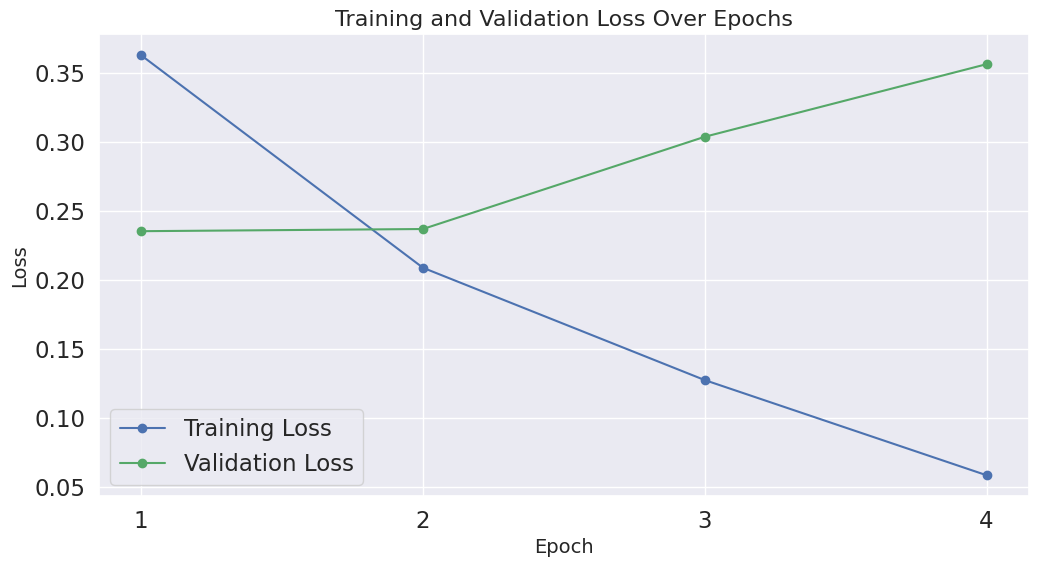

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.5)

plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")

plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)

plt.legend()
plt.xticks(range(1, len(df_stats) + 1))

plt.show()

In [ ]:
# Prediction on test set
print("Predicting labels for {:,} test sentences...".format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

predictions, true_labels = [], []

for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    # Forward pass, calculate logit predictions.
    result = model(
      b_input_ids,
      token_type_ids=None,
      attention_mask=b_input_mask,
      return_dict=True
    )

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 578 test sentences...
    DONE.


In [ ]:
# use MCC here because the classes are imbalanced
print('Positive samples: %d of %d (%.2f%%)' % (df_copy.LABEL.sum(), len(df_copy.LABEL), (df_copy.LABEL.sum() / len(df_copy.LABEL) * 100.0)))

Positive samples: 2934 of 5783 (50.73%)


In [ ]:
# MCC for imbalanced data
from sklearn.metrics import matthews_corrcoef

matthews_set = []
print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


<ipython-input-65-6fa57746ed05>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None, palette='pastel')


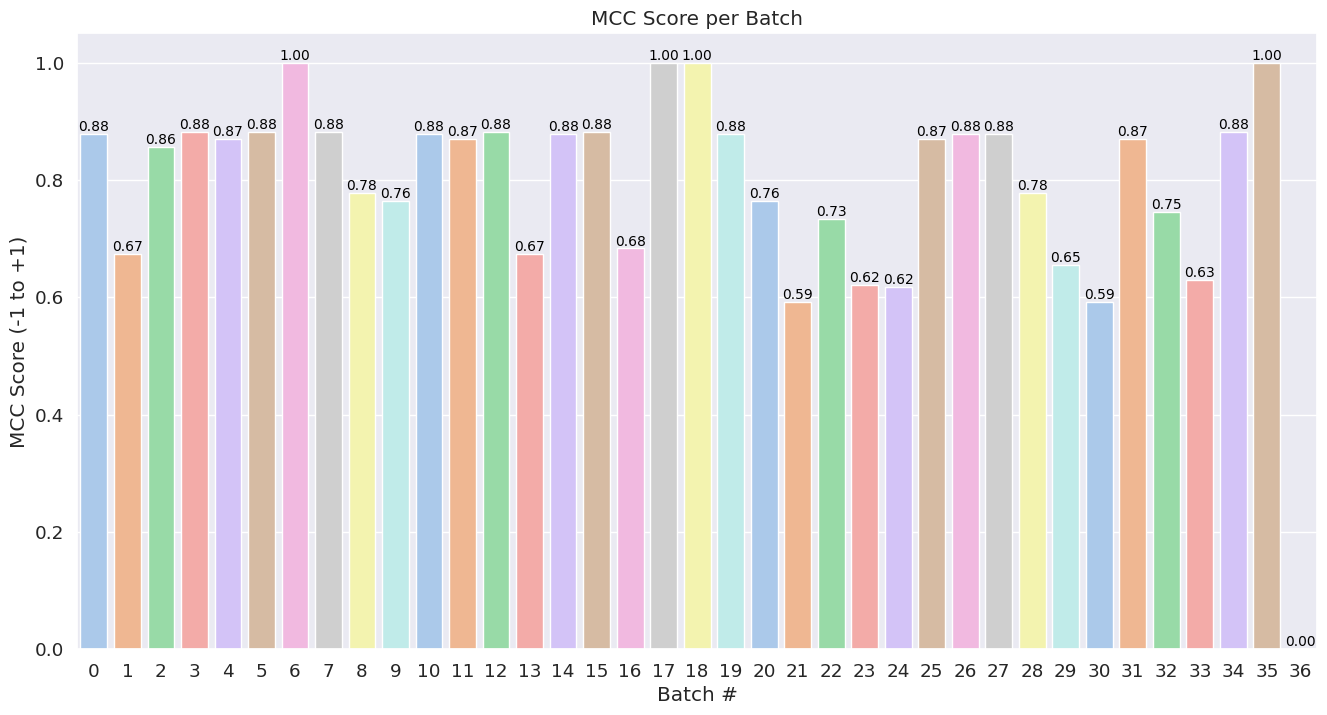

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
sns.set(style='whitegrid')
sns.set(font_scale=1.2)

plt.rcParams["figure.figsize"] = (16, 8)

ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None, palette='pastel')

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f'{matthews_set[i]:.2f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: %.3f' % mcc)

Total MCC: 0.808


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
acc = accuracy_score(flat_true_labels, flat_predictions)
precision = precision_score(flat_true_labels, flat_predictions)
recall = recall_score(flat_true_labels, flat_predictions)
f1 = f1_score(flat_true_labels, flat_predictions)

# Display metrics
print(f"Overall Metrics:")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Overall Metrics:
Accuracy: 0.903
Precision: 0.931
Recall: 0.873
F1 Score: 0.901


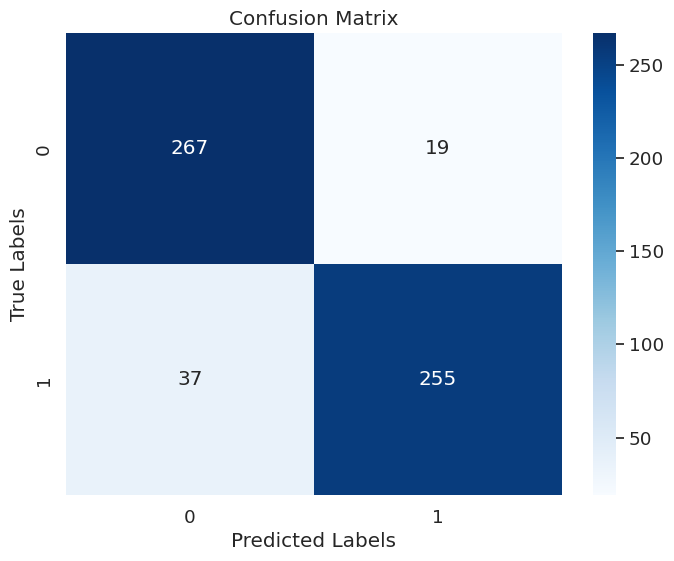

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Plot Confusion Matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
class_labels = unique_labels(flat_true_labels, flat_predictions)

sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))

ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Display Classification Report
class_report = classification_report(flat_true_labels, flat_predictions)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       286
           1       0.93      0.87      0.90       292

    accuracy                           0.90       578
   macro avg       0.90      0.90      0.90       578
weighted avg       0.90      0.90      0.90       578

